# Hoxhunt Summer Hunters 2021 - Data - Home assignment


## Tool description
This tool demonstrates a very simple method for detecting possible potential phishing sites from a set of URLs.
The tool mimics *some* detection methods for possible phishing sites described in the papers linked in the home assignment, but does it in a very simple way. 


The tool works as follows:  

1. It fetches potential phishing urls from phishtank.com. This is done by fetching a url listing page and parsing the url data out of html using BeautifulSoup4. The user can configure how many pages are parsed through - one page has 20 urls, of which ~10 are usually usable. These are collected into a list, and duplicates are removed. 
    Alternatively, a local csv file is used instead of scraping.

2. The tool checks for URL age in days for all urls in the list.

3. The tool processes and grades urls in the list. External css, image and script links add up one point for each link. All urls below one point are discarded. A new object list is generated containing url, points and age in days. This takes time as some urls are slow.

4. Some urls are discarded based on several properties:   
    -Url's age information is not available (comparison with point data not possible)  
    -Url's points are too much below average (possible good/not a phishing url)  
    -Url's age is above average (possible good/not a phishing url)  

5. Results are plotted using matplotlib. 

## Usage instructions:
The tool can be run with either processed data, or with raw url data. See the end of code block for options.

*Consider this when running the phishtank scraper option and/or the url data scraping option: all operations run on a single thread, hence the process is slow.   Setting the pages scraped amount anything over 10-ish tends to result in long processing times. This might also get your ip blocked by Phishtank for a while.*  

For demonstration purposes I've provided two csv files to speed up processing:  
urls.csv: Contains a set of 1900-ish urls scaped from Phistank (on 25th of Feb 2021)  
out.csv: Contains processed data from urls.csv - this is the demo material.



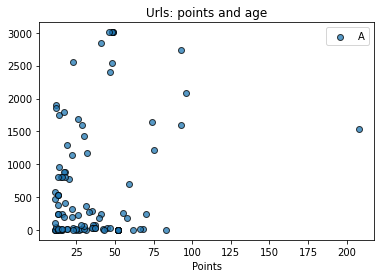

In [17]:
import requests
from bs4 import BeautifulSoup
import json
from urllib.parse import urlparse
import re
from matplotlib import pyplot as plt
import csv


# set amount of pages to fetch from Phistank
pages = 1


# import urls from csv. If error, import from phistank
def import_urls():
    urls = []
    try:
        with open('urls.csv') as csvfile:
            csv_reader = csv.reader(csvfile)
            for url in csv_reader:
                urls.append(url[0])
    except Exception as e:
        print('error ', e)
        print('csv import failed, fetching urls from phistank...')
        urls = get_fresh_urls_from_phistank(pages)
    return(urls)


# import processed urls from csv file - for demo purposes only
def import_processed_csv():
    urls = []
    try:
        with open('out.csv', 'r') as csvfile:
            csv_reader = csv.reader(csvfile)
            next(csv_reader)
            for row in csv_reader:
                urls.append(GradedUrl(row[0], row[1], row[2]))

    except Exception as e:
        print('error reading out.csv ', e)
    return(urls)


# fetch fresh(?) potential phising urls from phistank.
def get_fresh_urls_from_phistank(pages):
    pageNum = 0
    urls = []
    # scrape url listing page
    for pageNum in range(pages):
        source = requests.get('https://www.phishtank.com/phish_search.php?page=' +
                              str(pageNum) + '&active=y&valid=u&Search=Search').text
        main = BeautifulSoup(source, 'lxml')
        for td in main.find('body').find_all('td'):
            # scrape phish detail urls
            for a in td.find_all('a'):
                if (re.search('phish_detail', str(a))):
                    a = re.split('"', str(a))[1]
                    details_source = requests.get(
                        'https://www.phishtank.com/' + a).text
                    details = BeautifulSoup(details_source, 'lxml')
                    # add url grabbed from details page to list
                    for b in details.find('body').find_all('b'):
                        if ('http' in str(b)):
                            url = re.split('<', (re.split('>', str(b)))[1])[0]
                            urls.append(url)
    # clean up list (doesnt seem to work?)
    urls = list(dict.fromkeys(urls))
    # export urls as csv
    with open('urls.csv', 'w') as f:
        f.write('full_url')
        f.write('\n')
        for url in urls:
            f.write(str(url))
            f.write('\n')
    print('Done! ', len(urls), " urls fetched.")
    return(urls)


# class for url data
class GradedUrl:
    def __init__(self, url, points, age):
        self.url = url
        self.points = int(points)
        self.age = int(age)


def parse_domain_from_url(url):
    t = urlparse(url).netloc
    return '.'.join(t.split('.')[-2:])


def get_domain_age_in_days(domain):
    show = "https://input.payapi.io/v1/api/fraud/domain/age/" + domain
    data = requests.get(show).json()
    return data['result'] if 'result' in data else None


# get averages for points & age of all urls processed
def getAverages(gradedUrls):

    count_points = 0
    count_age = 0
    for GradedUrl in gradedUrls:
        count_points = count_points + GradedUrl.points
        count_age = count_age + GradedUrl.age
    avg_points = int(count_points / len(gradedUrls))
    avg_age = int(count_age / len(gradedUrls))
    averages = [avg_points, avg_age]
    return averages


# grade each scraped url and add to gradedUrls list
def grade_urls(urls):
    print('Processing ', len(urls), ' urls...')
    gradedUrls = []
    for url in urls:
        print('processing url: ', url)
        points = 0
        # if url path is long, add points
        if (len(urlparse(url).path) > 1):
            points += int(len(urlparse(url).path) / 5)
        # if subdomains and/or dashes in url, add points
        if ('.' or '-' in urlparse(url).netloc):

            points += int((urlparse(url).netloc).count('.') * 2)
            points += int((urlparse(url).netloc).count('-') * 2)

        try:
            # get domain age
            age = get_domain_age_in_days(parse_domain_from_url(url))
        # scrape url
            source = requests.get(url, timeout=10).text
            soup = BeautifulSoup(source, 'lxml')

            # find all external css, img & script defs, add 1 point for each.
            try:
                # css:
                for extCss in soup.find('head').find_all('link'):
                    if ('http' or 'https' in extCss):
                        # print('found ext css: ', url)
                        points += 1
                    else:
                        continue
                # img:
                for extImg in soup.find('body').find_all('img'):
                    if ('http' or 'https' in extImg):
                        # print('found ext img: ', url)
                        points += 1
                    else:
                        continue
                # scripts
                for extJs in soup.find('body').find_all('script'):
                    if ('http' or 'https' in extJs) and (url not in extJs):
                        # print('found ext scripts: ', url)
                        points += 1
                    else:
                        continue

            # if error, log and move on
            except Exception as e:
                print('discarding url, error in parsing: ', url,
                      ' age / points :', age, ' / ', points)
                pass

        # if  error in request(), log and move on. If ssl error (most likely bad cert), add 20 points
        except Exception as e:
            if 'ssl' in str(e).lower():
                print('ssl error')
                points += 20
                pass
            else:
                print('discarding url, error in request(): ', url,
                      ' age / points :', age, ' / ', points)
                continue
        # add urls to graded urls list
        if (points > 1 and age != None):
            gradedUrls.append(GradedUrl(url, points, age))
            print('adding url: ', url,
                  ' age / points :', age, ' / ', points)
        else:
            print('discarding url: ', url,
                  ' age / points :', age, ' / ', points)
    return (gradedUrls)


# plot data using matplotlib
def plot_data(urls):
    # uncomment below line for full url processing
    #gradedUrls = grade_urls(urls)

    # comment below for demo data processing
    gradedUrls = urls

    averages = getAverages(gradedUrls)
    x = []
    y = []

    for url in gradedUrls:
        # discard any url with age above average and points below average
        if (url.age < averages[1] and url.points > (averages[0] - 10)):
            x.append(url.points)
            y.append(url.age)
    plt.scatter(x, y, edgecolor='black', linewidth=1, alpha=0.75)

    plt.title('Urls: points and age')
    plt.xlabel('Points')
    plt.legend('Age')
    plt.show()

    # export results to csv (with no stripping by averages)

    # with open("out.csv", "w") as f:
    #     writer = csv.writer(f)
    #     wr = csv.DictWriter(f, delimiter="\t", fieldnames='url, points, age')
    #     writer.writerow(['url', 'points', 'age'])
    #     for url in gradedUrls:
    #         writer.writerow([url.url, url.points, url.age])


# for demo purposes, run plot with demo material.
# Comment below line and uncomment 'plot_data(import_urls())' line to run the grading process.
plot_data(import_processed_csv())
# plot_data(import_urls())


## Results and afterthoughts

As seen from the plotted data above, there seems to be some correlation with the url's age and suspicious properties of it. No valid decision could be made however, as the methods used in grading the urls are rudimentary. More data could be gathered from an url, and it could be processed more using machine learning techniques. 

